In [47]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from keras.models import Sequential
from keras import layers
from keras.layers import Embedding

import seaborn as sns
sns.set(style = 'whitegrid')

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

In [48]:
df = pd.read_csv('../Clean_Dataset.csv', encoding='UTF-8')

In [49]:
train = df[['Clean_Text','Stop_Words_Text', 'Stemmed_Text', 'indonlp_sentiment', 'Lexicon_Score']]

In [50]:
len(df['Clean_Text'])

42404

#### Data Preprocessing

In [51]:
data = df['Clean_Text'].values.tolist()

In [52]:
print(data[:5])

['cina dan as terus bersaing mengembangkan teknologi terbaru termasuk kali ini perusahaan di kedua negara berlomba lomba membangun dunia virtual atau metaverse', 'katanya mau metaverse tapi down melulu bagaimana mas zuck', 'mungkin facebook sudah berencana menjadi metaverse besar secara sudah menyiapkan diem sebagai stable curency mereka kalau emang iya pasti nanti pindah ke blokchain semua facebook masih menang banyak karena hanya memerlukan pembaruan teknologi penggunanya sudah banyak', 'bersaing dengan perusahaan kelas dunia untuk mencapai hal ini sektor publik dan swasta harus bersatu untuk membentuk ekosistem metaverse yang melibatkan teknologi ar vr dan xr dalam forum tersebut juga dibahas bagaimana mensukseskan platform ini dengan pasar konsumen', 'metaverse belum diadaptasi masif masih terus dikembangkan nyatanya hari ini kita kadang sudah bingung ujung pangkal dari persinggugangan realita empiris dan realita artifisial waw']


### Building a Model

#### Label Encoding of Output

In [57]:
import tensorflow as tf
labels = np.array(train['indonlp_sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

##### Bag of Words (BOW) feature extraction

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix

# Define the stop words
stop_words = stopwords.words('indonesian')

# Create a bag of words representation of the data
vectorizer = CountVectorizer(stop_words=stop_words, max_features=100)
bow = vectorizer.fit_transform(data)
tweets = bow.toarray()
print(tweets)

C:\Users\Juniarta\anaconda3\envs\tf\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Tokenizing and Adding Padding

In [75]:
max_words = 50000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
X = pad_sequences(sequences, maxlen=max_len)
print(X)

[[    0     0     0 ...    30    44     1]
 [    0     0     0 ...    62   220  1547]
 [    0     0     0 ...  1596    10    47]
 ...
 [    0     0     0 ...  2032    42  3087]
 [    0     0     0 ...  1951   735 15686]
 [    0     0     0 ...   199     2   638]]


In [76]:
scaler = MinMaxScaler()

In [77]:
# extract sentiment scores
sentiment_scores = df['Lexicon_Score'].values

# perform min-max scaling on sentiment scores
scaler = MinMaxScaler()
sentiment_scaled = scaler.fit_transform(sentiment_scores.reshape(-1, 1))

df['Sentiment_Scaled'] = sentiment_scaled 

In [78]:
df['Sentiment_Scaled']

0        0.585938
1        0.500000
2        0.695312
3        0.578125
4        0.625000
           ...   
42399    0.476562
42400    0.507812
42401    0.492188
42402    0.453125
42403    0.531250
Name: Sentiment_Scaled, Length: 42404, dtype: float64

In [79]:
#Combine sentiment scores with text data
X = np.hstack((sentiment_scaled, X))
y = labels

In [80]:
print(X.shape)

(42404, 101)


In [81]:
X = X[:, :-1]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33923, 100) (33923, 3)
(8481, 100) (8481, 3)


#### Using BiDirectional RNN and LSTM

In [83]:
embedding_layer = Embedding(1000, 64)

In [84]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

#### Train the Model

In [85]:
history = model2.fit(X_train, y_train, epochs=10,validation_split=0.2)

Epoch 1/10
849/849 [==============================] - 69s 73ms/step - loss: 0.7110 - accuracy: 0.6959 - val_loss: 0.5570 - val_accuracy: 0.7711
Epoch 2/10
849/849 [==============================] - 60s 71ms/step - loss: 0.4894 - accuracy: 0.8055 - val_loss: 0.5187 - val_accuracy: 0.7826
Epoch 3/10
849/849 [==============================] - 59s 70ms/step - loss: 0.3838 - accuracy: 0.8505 - val_loss: 0.5324 - val_accuracy: 0.7808
Epoch 4/10
849/849 [==============================] - 56s 66ms/step - loss: 0.3151 - accuracy: 0.8797 - val_loss: 0.5538 - val_accuracy: 0.7751
Epoch 5/10
849/849 [==============================] - 56s 66ms/step - loss: 0.2682 - accuracy: 0.8986 - val_loss: 0.5972 - val_accuracy: 0.7695
Epoch 6/10
849/849 [==============================] - 56s 66ms/step - loss: 0.2391 - accuracy: 0.9089 - val_loss: 0.6257 - val_accuracy: 0.7721
Epoch 7/10
849/849 [==============================] - 59s 70ms/step - loss: 0.2161 - accuracy: 0.9188 - val_loss: 0.6742 - val_accuracy:

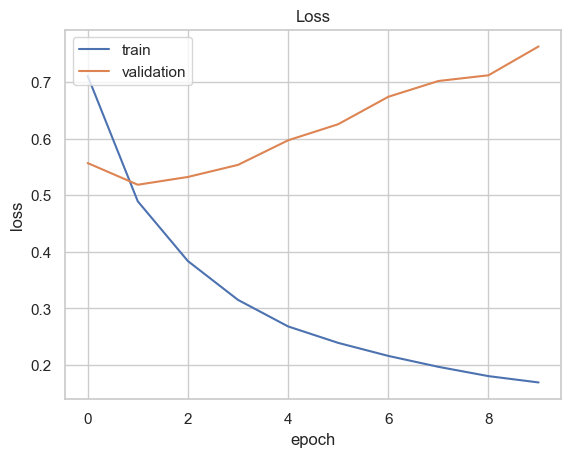

In [86]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

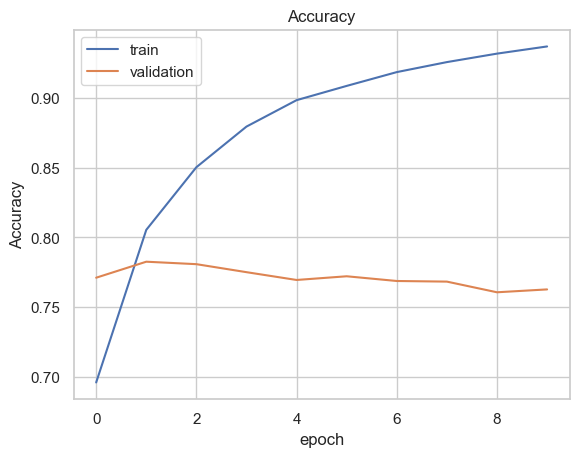

In [87]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

266/266 [==============================] - 5s 12ms/step
Model Accuracy on Test Data: 0.7586369531894823


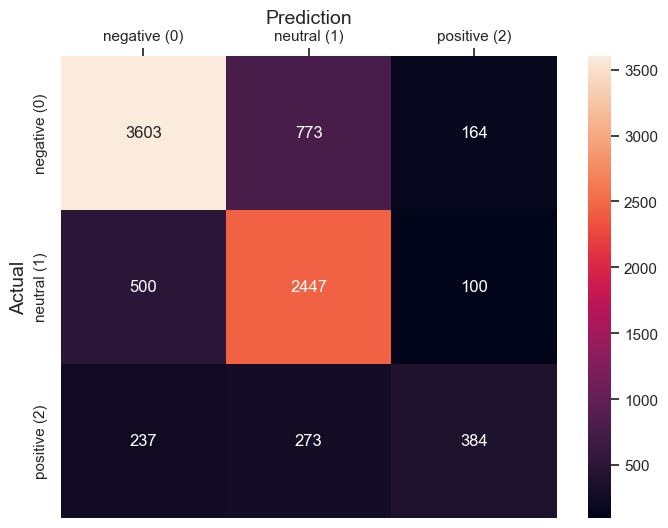

In [88]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = np.argmax(model2.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), fmt='g', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize=14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize=14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()


In [89]:
# predict classes for test set
y_pred = np.argmax(model2.predict(X_test), axis=-1)

# convert one-hot encoded true labels to integer class labels
y_test_int = np.argmax(y_test, axis=1)

# calculate metrics
print(classification_report(y_test_int, y_pred))

# calculate confusion matrix
conf_mat = confusion_matrix(y_test_int, y_pred)
print(conf_mat)


266/266 [==============================] - 3s 12ms/step
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4540
           1       0.70      0.80      0.75      3047
           2       0.59      0.43      0.50       894

    accuracy                           0.76      8481
   macro avg       0.71      0.68      0.69      8481
weighted avg       0.76      0.76      0.76      8481

[[3603  773  164]
 [ 500 2447  100]
 [ 237  273  384]]


#### Prediction and Result

In [90]:
sentiment = ['Neutral', 'Negative', 'Positive']

In [91]:
sequence = tokenizer.texts_to_sequences(['metaverse teknologi yang sangat buruk'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 1s 1s/step


'Negative'

In [92]:
sequence = tokenizer.texts_to_sequences(['wow metaverse teknologi yang sangat menjanjikan'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 33ms/step


'Positive'

In [93]:
sequence = tokenizer.texts_to_sequences(['kita lihat saja bagaimana perkembangan teknologi tersebut'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 33ms/step


'Neutral'

#### Building Model again with some Regularization

In [94]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.BatchNormalization())
model.add(layers.Bidirectional(layers.LSTM(15,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
history2 = model.fit(X,y, epochs=20,validation_split=0.2)

Epoch 1/20
1061/1061 [==============================] - 63s 52ms/step - loss: 0.7726 - accuracy: 0.6672 - val_loss: 0.6297 - val_accuracy: 0.7572
Epoch 2/20
1061/1061 [==============================] - 54s 51ms/step - loss: 0.6344 - accuracy: 0.7376 - val_loss: 0.5911 - val_accuracy: 0.7677
Epoch 3/20
1061/1061 [==============================] - 54s 51ms/step - loss: 0.5818 - accuracy: 0.7614 - val_loss: 0.5582 - val_accuracy: 0.7842
Epoch 4/20
1061/1061 [==============================] - 55s 52ms/step - loss: 0.5498 - accuracy: 0.7753 - val_loss: 0.5410 - val_accuracy: 0.7836
Epoch 5/20
1061/1061 [==============================] - 55s 51ms/step - loss: 0.5280 - accuracy: 0.7853 - val_loss: 0.5325 - val_accuracy: 0.7879
Epoch 6/20
1061/1061 [==============================] - 63s 60ms/step - loss: 0.5139 - accuracy: 0.7923 - val_loss: 0.5419 - val_accuracy: 0.7893
Epoch 7/20
1061/1061 [==============================] - 60s 57ms/step - loss: 0.4982 - accuracy: 0.7990 - val_loss: 0.5386 -

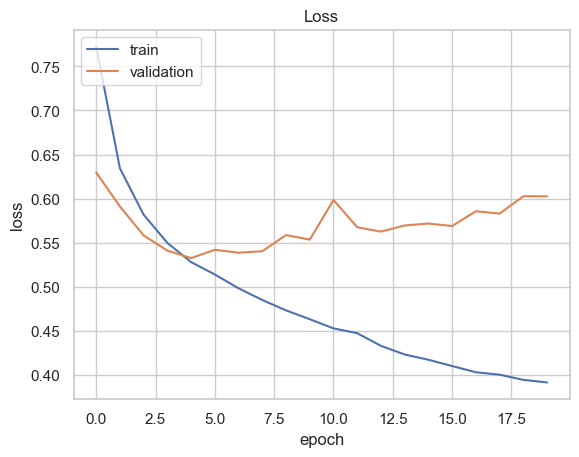

In [96]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

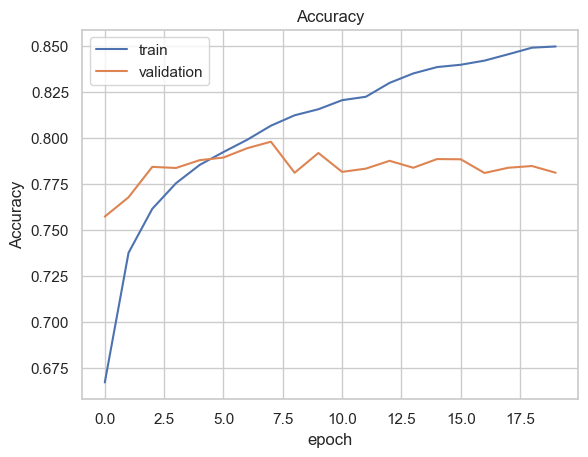

In [97]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

266/266 [==============================] - 5s 10ms/step
Model Accuracy on Test Data: 0.8579176983846245


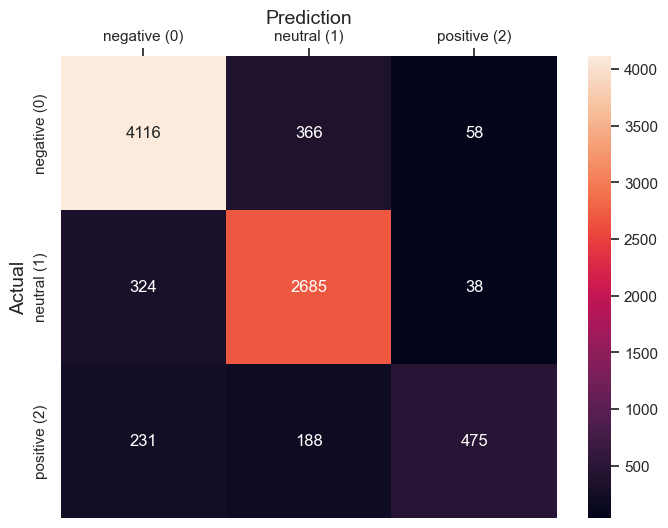

In [98]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), fmt='g', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize=14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize=14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()


In [99]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# predict classes for test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# convert one-hot encoded true labels to integer class labels
y_test_int = np.argmax(y_test, axis=1)

# calculate metrics
print(classification_report(y_test_int, y_pred))

# calculate confusion matrix
conf_mat = confusion_matrix(y_test_int, y_pred)
print(conf_mat)


266/266 [==============================] - 3s 10ms/step
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4540
           1       0.83      0.88      0.85      3047
           2       0.83      0.53      0.65       894

    accuracy                           0.86      8481
   macro avg       0.85      0.77      0.80      8481
weighted avg       0.86      0.86      0.85      8481

[[4116  366   58]
 [ 324 2685   38]
 [ 231  188  475]]


In [100]:
sequence = tokenizer.texts_to_sequences(['pada sadar tidak yang namanya metaverse kok kyknya bakal jadi satu kegilan baru era digital'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 41ms/step


'Negative'

In [101]:
sequence = tokenizer.texts_to_sequences(['kita lihat saja bagaimana perkembangan teknologi metaverse kedepannya'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 38ms/step


'Neutral'

In [102]:
sequence = tokenizer.texts_to_sequences(['teknologi yang sangat menjanjikan, semoga dapat diterapkan secara masif'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 38ms/step


'Positive'